In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import random
import time
from network import *
import simpy

In [2]:
def wait(val):
    time.sleep(val * 0.01)

In [3]:
%matplotlib notebook
plt.ion()

In [4]:
SIMULATION = True

In [5]:
env = simpy.Environment()

In [6]:
N = Network("stations.txt" , "railway.txt" , env)

In [7]:
for _ in range(5):
    N.lock_station('Alpha' , '_')

In [8]:
N.lock_track('Alpha' , 'Beta' , '_')

0

In [9]:
N.free_station('Alpha' , 0 ,)
N.free_station('Alpha' , 2 ,)

In [10]:
N.free_track('Alpha' , 'Beta' , 0)

<IPython.core.display.Javascript object>


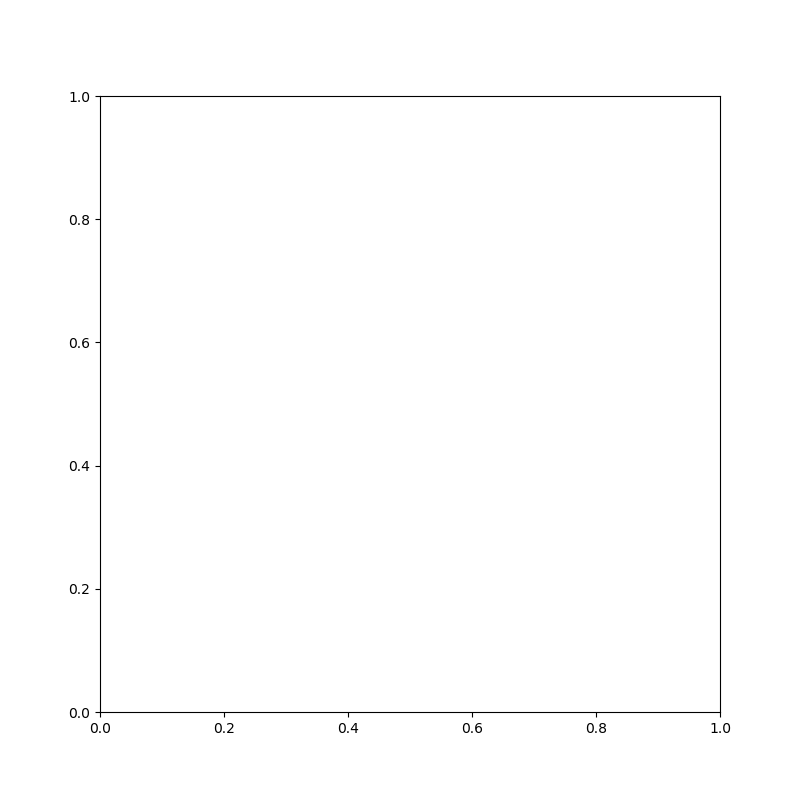

In [11]:
fig = plt.figure(figsize = (8 , 8))
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

In [19]:
for _ in range(10):
    time.sleep(0.1)
    r = random.randint(0,4)
    N.lock_station('Alpha' , '_')
    N.free_station('Alpha' , r)
    N.lock_track('A' , 'B' , '_')
    N.free_track('A' , 'B' , r)
    N.draw_railway_network(ax  = ax , suppress_station_info=False , suppress_track_info= False , suppress_edge_label=False)
    fig.canvas.draw()

In [12]:
#Creating the train class
class Train:
    id_ = 0
    def __init__ (self  , name , avg_speed , priority , route  , env , network):
        '''
        @parameters 
        name         : name of the train
        avg_speed    : average speed of the train
        priority     : priority of the train, later will be used in the algorithm
        route        : a python list of touple that gives the stations on the route along with the expected time 
                       of departure
        env          : Simpy environment where simulation is done
        network      : network on which the train is running 
        
        TODO
        ____________________________________
        
        Notes :
        Time is just an integer for current. It can change in the future.
        Simmulation starts at time 0. So the time in the route should always be greater than 0
        
        '''
        
        #initialise the variables
        self.__class__.id_ += 1
        self.id = self.__class__.id_
        self.name = name
        self.speed = avg_speed
        self.priority = priority
        self.route = route
        self.env = env              
        self.network = network

        #for the current status of the train
        self.running = False                        #True if the train is running                        
        self.station_or_not = False                 #True if standing on station
        self.current = '_'                          #Current station name or the track (tuple)
        self.current_index = -1                     #upto which point the route is travelled
        
        #Create the relevant processes
        self.initiate_train_proc = env.process (self.initiate_train(self.env))
        
        #resource that the train is acquiring currently
        self.resource = None                     
        
    def compute_time (self , distance):
        '''
        returns the time needed to travel the distance  
        @paramters :
        distance : to be travelled
        '''
        return distance/self.speed
    
    def initiate_train (self , env):
        '''
        This train puts the train on the track
        '''
        start_station , start_time = route[0]
        
        #wait till the right time comes to be on train
        yield env.timeout(start_time)
        
        #try to acquire the resource related to the resource
        #It may be possible that the station is all full and the train cannot be put there.
        #In that case, we have to wait to put train on the station
        resource = self.network.get_station_resource (start_station)
        request = resource.request()
        yield request
        self.resource = resource
        
        #update the current status
        self.current_index = 0 
        self.current = start_station
        self.station_or_not = True
        self.running = True
        
        #move the train (only for the simulation purpose, not for the algorithm)
        move_train_proc = self.process(self.move_train(env))
        yield move_train_proc
        
        
    def move_train (self , env):
        '''
        This function runs the train
        This function may only be used for simulation purpose
        '''
        '''
        TODO
        move train one step at a time
        '''
        
    def move_train_one_step (self, env):
        '''
        Move the train
        This function does not move the train before the tentative time table
        If already reached destination then returns -1
        '''
        if (self.station_or_not):
             
            '''
            TODO
            move the train when the train is on the station to the track
            This will also completely travel the track
            '''
        
            if (self.current_index == len(self.route) - 1):
                return -1

            current_station , depart_time = self.route[self.current_index]
            next_station , dest_time = self.route[self.current_index + 1]
            current_time = env.now

            #wait
            wait = max(0 , depart_time - current_time)
            yield env.timeout (wait)
        
        else:
            '''
            TODO
            Move the train from the track to the station
            '''
        
        
        
        
        
    def print_details (self):
        '''
        Prints all the information of the train
        '''
        print(50 * '*')
        print("Train ID : {}".format(self.id_))
        print("Name :{}".format(self.name))
        print("Priority : {}".format(self.priority))
        print("Average speed : ".format(self.speed))
        if (self.running):
            print("Train is running")
            if (self.station_or_not):
                print("Currently at station {}".format(self.current))
            else:
                print("Currently on track {}-{}".format(self.current[0] , self.current[1]))
        else:
            print('Train not travelling')
        
        print("Route of the train")
        for d,t in self.route:
            print("            {} : {} ".format(d , t))
        print(50 * '*')
            

In [13]:
#initialize the variable for the instance
name = 'Shatabdi'
speed=1
priority = 3
route = [
        ('Alpha' , 10),
        ('Beta' ,  15),
        ('Gamma' , 27),
        ('Zeta' , 32),
        ]

In [14]:
train = Train (name , speed , priority , route , env , N)

TypeError: __init__() missing 1 required positional argument: 'network'

In [14]:
train.print_details()

**************************************************
Train ID : 1
Name :Shatabdi
Priority : 3
Average speed : 
Train not travelling
Route of the train
            Alpha : 10 
            Beta : 15 
            Gamma : 27 
            Zeta : 32 
**************************************************


In [15]:
# TODO
'''Create a simple train class with all the parameters
Implement the resource facility with the track and the station
Run the single train on the track (without getting worried wether the resource is free or not)
Run multiple instances of the train without worrying about the deadlock

Try to create deadlock with the trains
Create the graph for resource usage.
Use the standard deadlock detection algorithm for the detection of the algorithm
Implement the Bank's algorithm for deadlock detection.
'''

"Create a simple train class with all the parameters\nImplement the resource facility with the track and the station\nRun the single train on the track (without getting worried wether the resource is free or not)\nRun multiple instances of the train without worrying about the deadlock\n\nTry to create deadlock with the trains\nCreate the graph for resource usage.\nUse the standard deadlock detection algorithm for the detection of the algorithm\nImplement the Bank's algorithm for deadlock detection.\n"